<a href="https://colab.research.google.com/github/xiaolin5167/Github-Colab-Pytorch/blob/main/custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

How do you get your own data into pytorch?
One of the ways to do so is via: custom datasets.

Domain libraries
Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.

In [1]:
import torch
from torch import nn

torch.__version__

'2.1.0+cu121'

In [2]:
#setup device-agnostic code
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [3]:
!nvidia-smi

Thu Feb  8 06:24:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# 1.Get data
Our dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing).

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing).

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.

The whole point is to speed up how fast you can experiment.

In [4]:
import requests
import zipfile
from pathlib import Path

# set path to a data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# if the image folder doesn't exist, download it and prepare it
if image_path.is_dir():
  print(f'{image_path} directory already exists... skipping download')
else:
  print(f'{image_path} does not exist, creating one...')
  image_path.mkdir(parents=True,exist_ok=True)

# Download pizza, steak and suhsi data
with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print('download pizza, steak, suhsi data...')
  # write data binary (wb) into data_path / 'pizza_steak_sushi.zip'
  f.write(request.content)

# Unzip data
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
  print('Unzipping data...')
  zip_ref.extractall(image_path)


data/pizza_steak_sushi does not exist, creating one...
download pizza, steak, suhsi data...
Unzipping data...


In [5]:
image_path

PosixPath('data/pizza_steak_sushi')

# 2. Data preparation and data exploration

In [6]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.')

In [7]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi.
There are 3 directories and 0 images in data/pizza_steak_sushi/train.
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi.
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza.
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak.
There are 3 directories and 0 images in data/pizza_steak_sushi/test.
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi.
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza.
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak.


In [8]:
# Setup train and testing paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 1.1 Visualizing and image
Let's write some code to:
1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python's PIL
5. We'll then show the image and print metadata

random image path: data/pizza_steak_sushi/test/pizza/344397.jpg
image name: pizza
image's height: 342
image's width: 512


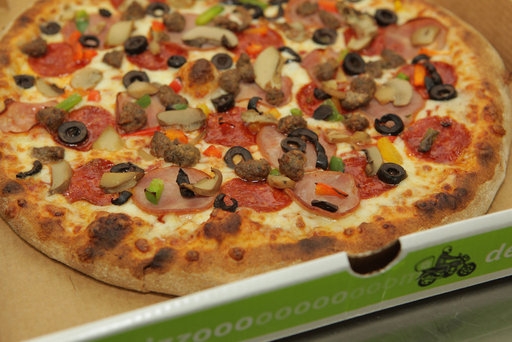

In [9]:
import random
from PIL import Image

# set seed
# random.seed(42)

# 1. get all image paths
image_path_list = list(image_path.glob('*/*/*'))
#image_path_list

# 2. pick a random image
random_image_path = random.choice(image_path_list)
# random_image_path

# 3. get class name of the image
image_class = random_image_path.parent.stem
# image_class

# 5. open the image
img = Image.open(random_image_path)
# img

# 6. print the metadata
print(f'random image path: {random_image_path}')
print(f'image name: {image_class}')
print(f'image\'s height: {img.height}')
print(f'image\'s width: {img.width}')
img

##### Visualising a random image with matplotlib

Text(0.5, 1.0, 'Image class: pizza | Image shape: (342, 512, 3) -> [height, width, color channel]')

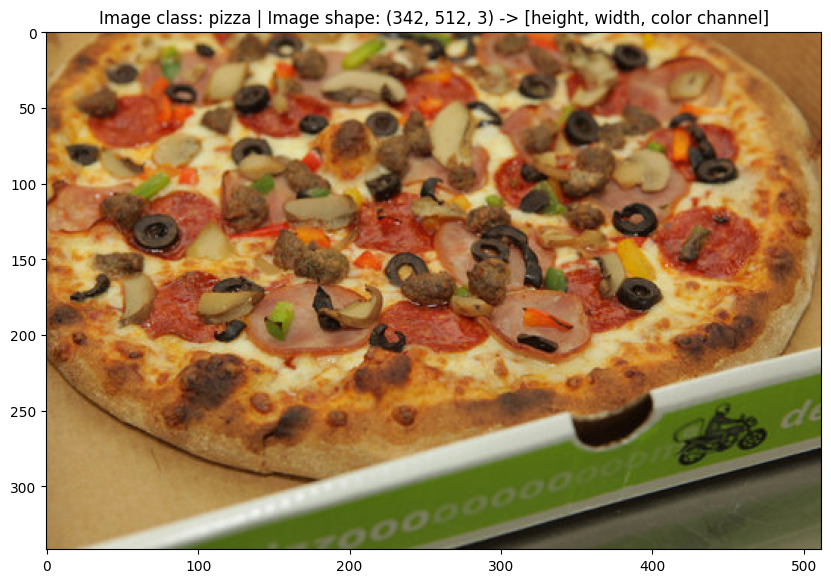

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f'Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color channel]')

In [11]:
# img_as_array

# 2.Transforming data
Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`.

In [12]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

##2.1 Transforming data with torchvision.transforms

Transforms help you get your images ready to be used with a model/perform data augmentation - https://pytorch.org/vision/stable/transforms.html

In [13]:
from typing_extensions import dataclass_transform
# Write a transform for image
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),# 依0.5的概率水平翻转
    transforms.ToTensor()
])

In [14]:
data_transform(img)

tensor([[[0.6157, 0.7059, 0.7451,  ..., 0.6275, 0.6235, 0.6392],
         [0.6431, 0.7059, 0.7451,  ..., 0.6196, 0.6157, 0.6235],
         [0.6863, 0.7255, 0.6980,  ..., 0.6196, 0.6157, 0.6235],
         ...,
         [0.6824, 0.6941, 0.7098,  ..., 0.3451, 0.3686, 0.3922],
         [0.6706, 0.6902, 0.7137,  ..., 0.3922, 0.4078, 0.4196],
         [0.6667, 0.6863, 0.7176,  ..., 0.4275, 0.4431, 0.4549]],

        [[0.4196, 0.5451, 0.5882,  ..., 0.4235, 0.4157, 0.4353],
         [0.4588, 0.5412, 0.5922,  ..., 0.4118, 0.4118, 0.4157],
         [0.5216, 0.5647, 0.5176,  ..., 0.4118, 0.4078, 0.4157],
         ...,
         [0.5373, 0.5529, 0.5765,  ..., 0.3608, 0.3765, 0.3922],
         [0.5294, 0.5490, 0.5765,  ..., 0.3961, 0.4039, 0.4157],
         [0.5216, 0.5451, 0.5843,  ..., 0.4196, 0.4314, 0.4431]],

        [[0.1961, 0.2941, 0.3216,  ..., 0.2039, 0.2039, 0.2157],
         [0.2275, 0.2941, 0.3255,  ..., 0.2000, 0.2000, 0.2039],
         [0.2667, 0.3059, 0.2824,  ..., 0.2078, 0.1961, 0.

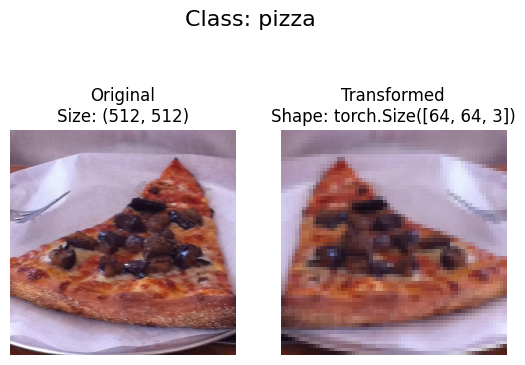

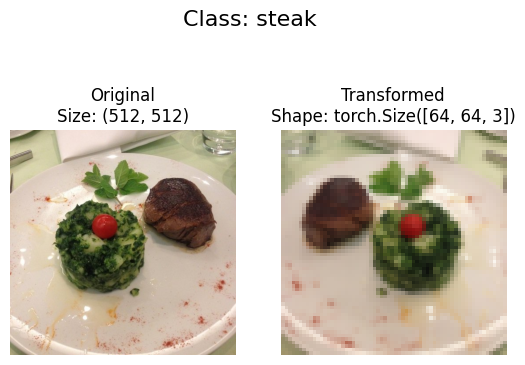

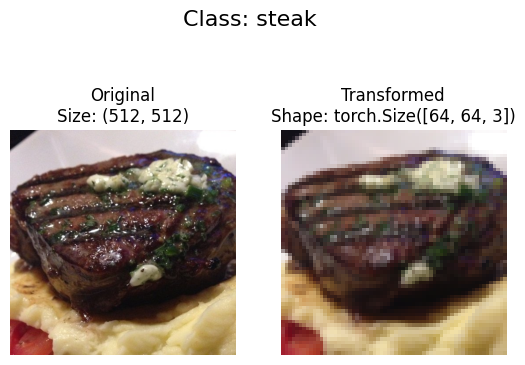

In [15]:
def plot_transformed_images(image_paths: list, transform, num_sample=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms them
  then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)

  random_image_paths = random.sample(image_paths, k=num_sample)

  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f'Original\nSize: {f.size}')
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1,2,0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'Transformed\nShape: {transformed_image.shape}')
      ax[1].axis('off')# same as axis(False)

      fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        num_sample=3,
                        seed=None)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder` - https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder

In [16]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [17]:
train_data.classes

['pizza', 'steak', 'sushi']

In [18]:
train_data.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [19]:
len(train_data),len(test_data)

(225, 75)

In [20]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [21]:
train_data[0]

(tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
          [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
          [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
          ...,
          [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
          [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
          [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],
 
         [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
          [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
          [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
          ...,
          [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
          [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
          [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],
 
         [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
          [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
          [0.0196, 0.0157, 0.0157,  ...,

original shape: torch.Size([3, 64, 64]) -> [color_channel, height, width]
image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

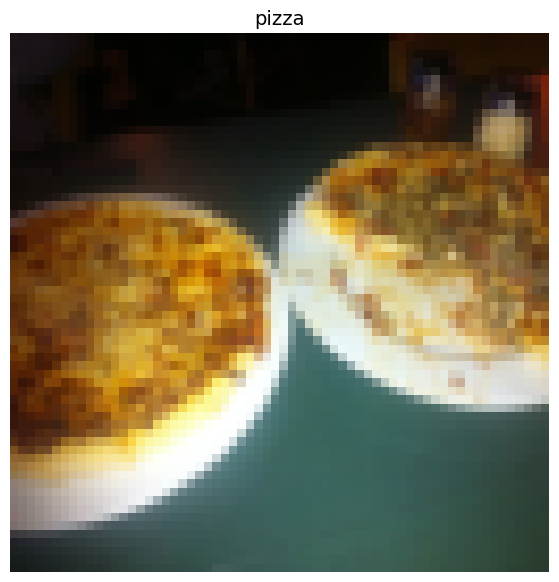

In [22]:
# Rearrange the order dimensions
img, label = train_data[0][0], train_data[0][1]
img_permute = img.permute(1,2,0)
class_names = train_data.classes

print(f'original shape: {img.shape} -> [color_channel, height, width]')
print(f'image permute: {img_permute.shape} -> [height, width, color_channels]')

# plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis('off')
plt.title(class_names[label], fontsize=14)

## 2.2 Turn loaded images into DataLoader's
A DataLoader is going to help us turn our Dataset's into iterables and we can customise the batch_size so our model can see batch_size images at a time.

In [23]:
import os
os.cpu_count()

2

In [24]:
# turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE=1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7d372523b4c0>,
 <torch.utils.data.dataloader.DataLoader at 0x7d372523bd00>)

In [25]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [26]:
img, label = next(iter(train_dataloader))
# Batch size will now be 1, you can change the batch size if you like
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## Option 2: Loading Image Data with a Custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it doesn't mean it will work...
* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues

All custom datasets in PyTorch, often subclass - https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset


In [27]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

### Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them.

In [28]:
# Setup path for target directory
target_directory = train_dir
#os.scandir() 是Python 中的一个函数，用于获取文件系统中目录的迭代器。 它可以遍历指定目录中的所有条目，包括文件和子目录。
list(os.scandir(target_directory))

[<DirEntry 'sushi'>, <DirEntry 'pizza'>, <DirEntry 'steak'>]

In [29]:
# Get the class names from the target directory
class_names_found = sorted([list(os.scandir(target_directory))])
class_names_found

[[<DirEntry 'sushi'>, <DirEntry 'pizza'>, <DirEntry 'steak'>]]

In [30]:
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

['pizza', 'steak', 'sushi']

In [31]:
for entry in os.scandir(target_directory):
  print(entry)
  print(entry.name)
  print(entry.path)

<DirEntry 'sushi'>
sushi
data/pizza_steak_sushi/train/sushi
<DirEntry 'pizza'>
pizza
data/pizza_steak_sushi/train/pizza
<DirEntry 'steak'>
steak
data/pizza_steak_sushi/train/steak


In [32]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory."""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f'Couldn\'t find any classes in {directory}...pls check')

  # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
  class_to_idx = {class_names: i for i, class_names in enumerate(classes)}
  return classes, class_to_idx

In [33]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [34]:
_,one_class = find_classes(target_directory)
one_class['pizza']

0

### Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
  * paths - paths of our images
  * transform - the transform we'd like to use
  * classes - a list of the target classes
  * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index

In [35]:
# Write a custom dataset class
from torch.utils.data import DataChunk

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self,
               targ_dir: str,
               transform=None):
  # 3. Create class attributes
  # Get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index:int) -> Image.Image:
    "Open an image via a path and return it."
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    "Return the total number of samples"
    return len(self.paths)

  # 6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X，y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]
    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx# return untransformed image and label


In [36]:
# Create a transform
from torchvision import transforms
train_transforms = transforms.Compose([transforms.Resize(size=(64,64)),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Resize(size=(64,64)),
                                      transforms.ToTensor()])

In [37]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [38]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7d372523ab00>,
 <__main__.ImageFolderCustom at 0x7d37252388e0>)

In [39]:
len(train_data_custom), len(train_data)

(225, 225)

### Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample indexes and plot them with matploltib.
7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [40]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int=10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. Setup plot
  plt.figure(figsize=(16,8))

  # 6. Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1,2,0)

    # Plot adjusted samples
    plt.subplot(1,n,i+1)
    plt.imshow(targ_image_adjust)
    plt.axis('off')
    if classes:
      title = f'Class: {classes[targ_label]}'
      if display_shape:
        title = title + f"\nshape': {targ_image_adjust.shape}"
    plt.title(title)


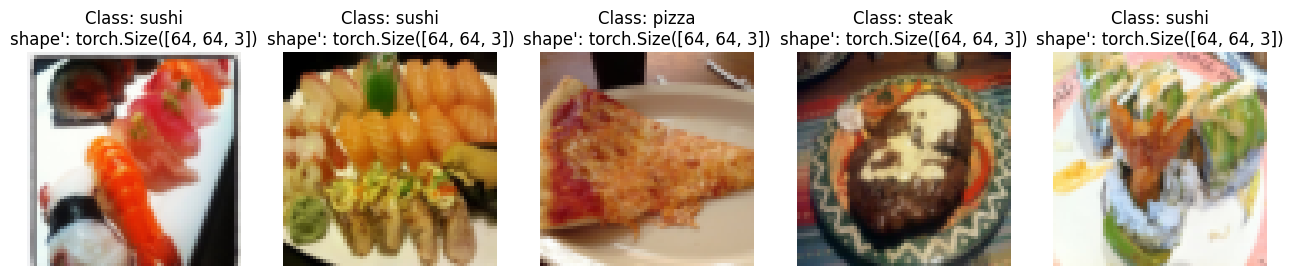

In [41]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

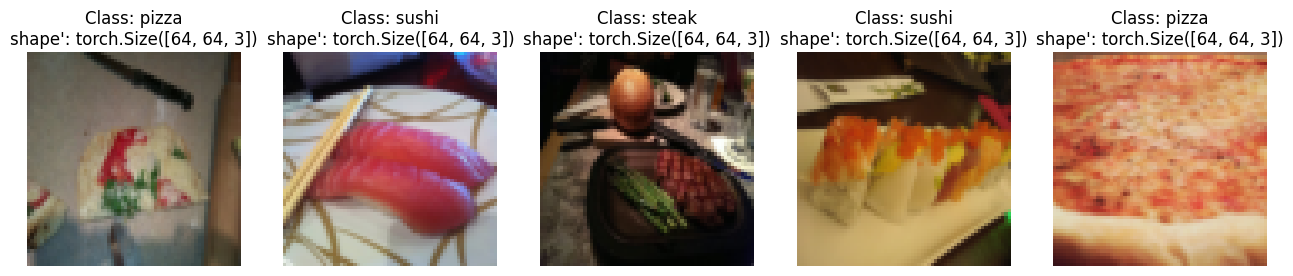

In [42]:
display_random_images(train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=None)

In [43]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader_custom = DataLoader(
    dataset=train_data_custom,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader_custom = DataLoader(
    dataset=test_data_custom,
    batch_size=BATCH_SIZE,
    shuffle=False
)

train_dataloader_custom,test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7d3725452080>,
 <torch.utils.data.dataloader.DataLoader at 0x7d37254520e0>)

In [44]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 2.3 Other forms of transforms (data augmentation)

Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training images.

This practice hopefully results in a model that's more generalizable to unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels...

Blog post: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/#break-down-of-key-accuracy-improvements

In [45]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=32),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

In [46]:
image_path

PosixPath('data/pizza_steak_sushi')

In [47]:
# Get all the image paths

image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list

[PosixPath('data/pizza_steak_sushi/train/sushi/390178.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/3360207.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2120573.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2641778.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1615453.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1070104.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/385154.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/121940.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1957449.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/3737197.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1129338.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2590819.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/3579071.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2017378.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/3251688.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/200025.jpg'),
 PosixPath('

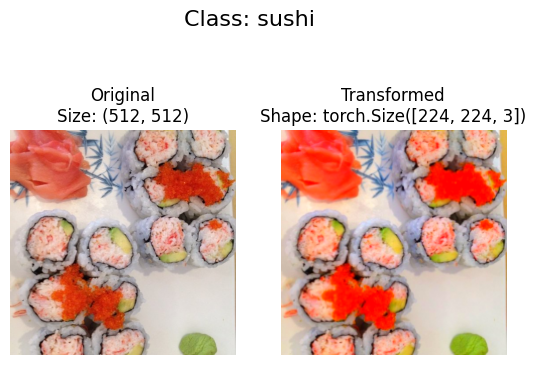

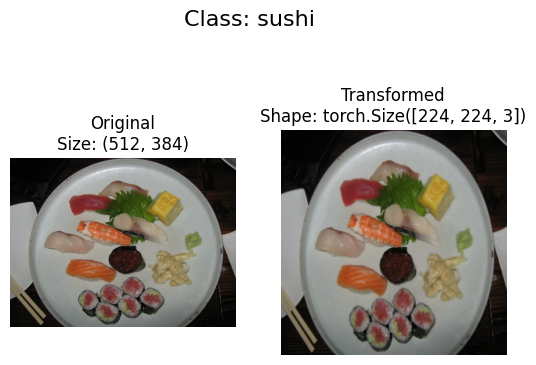

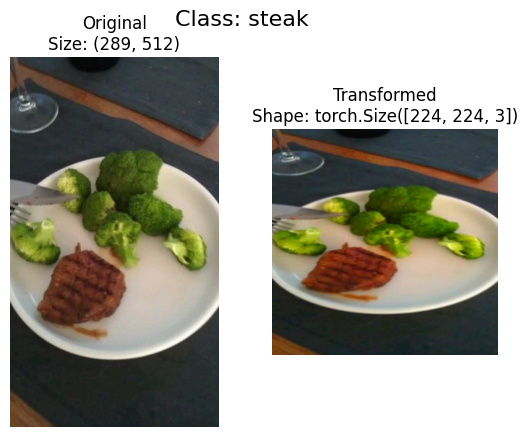

In [48]:
# Plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    num_sample=3,
    transform = train_transform,
    seed=None
)

# 3.Model 0: TinyVGG without data augmentation

Let's replicate TinyVGG architecture from the CNN Explainer website: https://poloclub.github.io/cnn-explainer/

### Creating transforms and loading data for Model 0

In [49]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [50]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(
    root=train_dir,
    transform=simple_transform
)

test_data_simple = datasets.ImageFolder(
    root=test_dir,
    transform=simple_transform
)

# 2. Turn the datasets into Dataloaders
import os
from torch.utils.data import DataLoader

# setup batch size and number of works
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count

train_dataloader_simple = DataLoader(
    dataset=train_data_simple,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader_simple = DataLoader(
    dataset=test_data_simple,
    batch_size=BATCH_SIZE,
    shuffle=False
)


### Create TinyVGG model class

In [51]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer: https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self,
               input_shape:int,
               hidden_units:int,
               output_shape:int) -> None:
      super().__init__()
      self.conv_block_1 = nn.Sequential(
          nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    padding=0),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                       stride=2)
      )

      self.conv_block_2 = nn.Sequential(
          nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=0),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                      stride=2)
      )

      self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=hidden_units*13*13,
                    out_features=output_shape)
      )

  def forward(self, x):
    # return self.clasifier(self.conv_block_1(self.conv_block_2(x)))
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x

In [52]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,# number of color channels in our image data
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### Try a forward pass on a single image (to test the model)

In [53]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape,len(train_dataloader_simple)

(torch.Size([32, 3, 64, 64]), torch.Size([32]), 8)

In [54]:
for i, (X,y) in enumerate(train_dataloader_simple):
  print(f'batch:{i})')

batch:0)
batch:1)
batch:2)
batch:3)
batch:4)
batch:5)
batch:6)
batch:7)


In [55]:
# Try a forward pass
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9129e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6417e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7980e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1815e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3994e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.2317e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### Use `torchinfo` to get an idea of the shapes going through our model

In [56]:
# Install torchinfo, import if it's available

try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) #[batch_size, num_channel, height, width]

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### Create train and test loops functions

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader.
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader.

In [57]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X,y) in enumerate(dataloader):
    # Set data to the target device
    X,y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1),dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss/len(dataloader)
  train_acc = train_acc/len(dataloader)
  return train_loss, train_acc

In [58]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put the model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0,0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X,y) in enumerate(dataloader):
      # Send data to the target device
      X,y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      print(f'loss:{loss},shape:{type(loss)}')
      test_loss += loss.item()
      print(f'loss.item():{loss.item()},shape:{type(loss.item())}')

      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [59]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloaders + loss function
def train(model: torch.nn.Module,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

  # 2. Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. Return the filled results at the end of the epochs
  return results

In [60]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels of our target images
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

loss:1.0962293148040771,shape:<class 'torch.Tensor'>
loss.item():1.0962293148040771,shape:<class 'float'>
loss:1.098143458366394,shape:<class 'torch.Tensor'>
loss.item():1.098143458366394,shape:<class 'float'>
loss:1.1005895137786865,shape:<class 'torch.Tensor'>
loss.item():1.1005895137786865,shape:<class 'float'>
Epoch: 0 | Train loss: 1.1063 | Train acc: 0.3047 | Test loss: 1.0983 | Test acc: 0.3011
loss:1.1350048780441284,shape:<class 'torch.Tensor'>
loss.item():1.1350048780441284,shape:<class 'float'>
loss:1.0601187944412231,shape:<class 'torch.Tensor'>
loss.item():1.0601187944412231,shape:<class 'float'>
loss:1.0139511823654175,shape:<class 'torch.Tensor'>
loss.item():1.0139511823654175,shape:<class 'float'>
Epoch: 1 | Train loss: 1.0998 | Train acc: 0.3281 | Test loss: 1.0697 | Test acc: 0.5417
loss:1.1560783386230469,shape:<class 'torch.Tensor'>
loss.item():1.1560783386230469,shape:<class 'float'>
loss:1.0415340662002563,shape:<class 'torch.Tensor'>
loss.item():1.041534066200256

In [61]:
model_0_results

{'train_loss': [1.1063194125890732,
  1.0997986495494843,
  1.0868990421295166,
  1.084609031677246,
  1.0663709789514542],
 'train_acc': [0.3046875, 0.328125, 0.48828125, 0.40234375, 0.41796875],
 'test_loss': [1.098320762316386,
  1.0696916182835896,
  1.0808486938476562,
  1.060613989830017,
  1.0659816265106201],
 'test_acc': [0.30113636363636365,
  0.5416666666666666,
  0.49242424242424243,
  0.5729166666666666,
  0.5643939393939394]}

### Plot the loss curves of Model 0

In [62]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [63]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictionary."""
  # Get the loss values of the results dictionary(training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how mnay epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

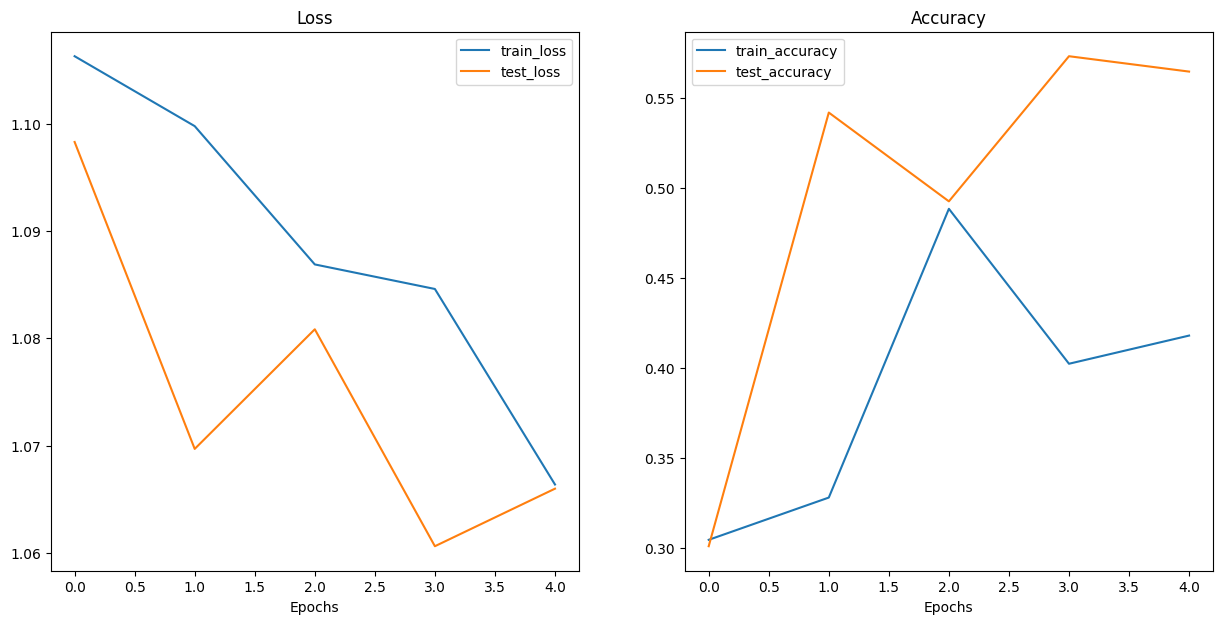

In [64]:
plot_loss_curves(model_0_results)

# 4.Model 1: TinyVGG with Data Augmentation

Create transform with data augmentation

In [65]:
# Create training transform with TriviailAugment
from torchvision import transforms
train_transform_trivial = transforms.Compose([
                                               transforms.Resize(size=(64, 64)),
                                               transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                               transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
                                            transforms.Resize(size=(64, 64)),
                                            transforms.ToTensor()
])

In [66]:
# Turn image folders into Datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)

In [67]:
# Turn our Datasets into DataLoaders
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

###Construct and train model 1

In [68]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [69]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 5

# Setup loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model 1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time for model_1: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

loss:1.079190969467163,shape:<class 'torch.Tensor'>
loss.item():1.079190969467163,shape:<class 'float'>
loss:1.1124285459518433,shape:<class 'torch.Tensor'>
loss.item():1.1124285459518433,shape:<class 'float'>
loss:1.1141598224639893,shape:<class 'torch.Tensor'>
loss.item():1.1141598224639893,shape:<class 'float'>
Epoch: 0 | Train loss: 1.1049 | Train acc: 0.2500 | Test loss: 1.1019 | Test acc: 0.2604
loss:0.9810653328895569,shape:<class 'torch.Tensor'>
loss.item():0.9810653328895569,shape:<class 'float'>
loss:1.19797682762146,shape:<class 'torch.Tensor'>
loss.item():1.19797682762146,shape:<class 'float'>
loss:1.1990469694137573,shape:<class 'torch.Tensor'>
loss.item():1.1990469694137573,shape:<class 'float'>
Epoch: 1 | Train loss: 1.0807 | Train acc: 0.4258 | Test loss: 1.1260 | Test acc: 0.2604
loss:0.9093027114868164,shape:<class 'torch.Tensor'>
loss.item():0.9093027114868164,shape:<class 'float'>
loss:1.275396466255188,shape:<class 'torch.Tensor'>
loss.item():1.275396466255188,shap

###Plot the loss curves of model 1

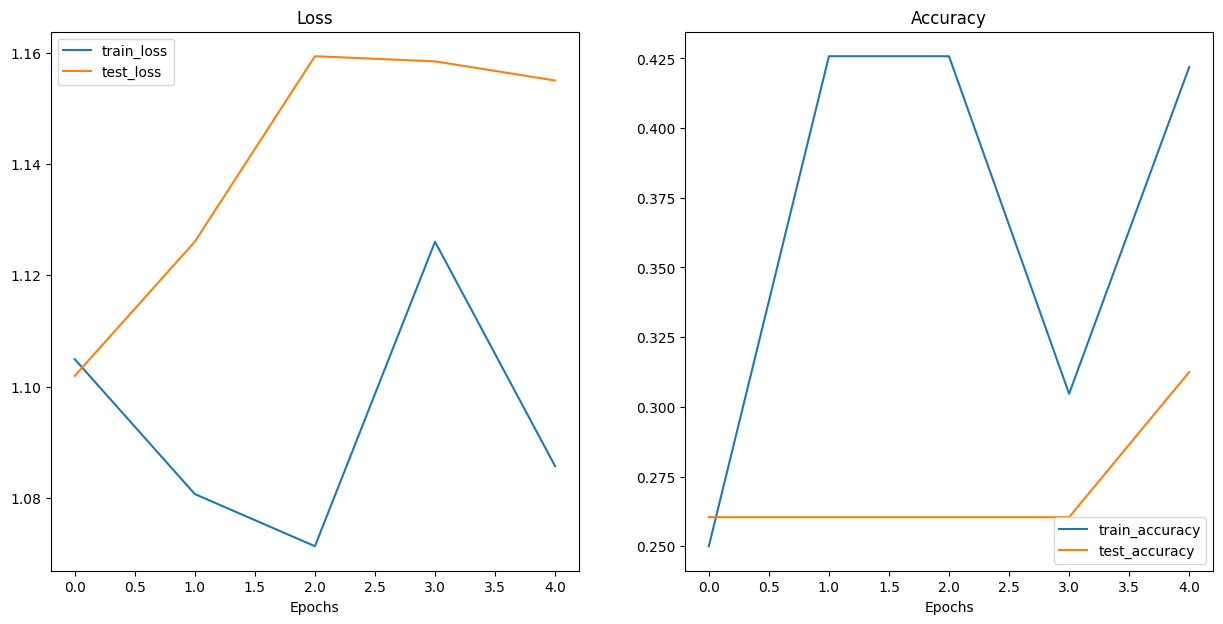

In [70]:
plot_loss_curves(model_1_results)

#5.Compare model results

In [71]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106319,0.304688,1.098321,0.301136
1,1.099799,0.328125,1.069692,0.541667
2,1.086899,0.488281,1.080849,0.492424
3,1.084609,0.402344,1.060614,0.572917
4,1.066371,0.417969,1.065982,0.564394


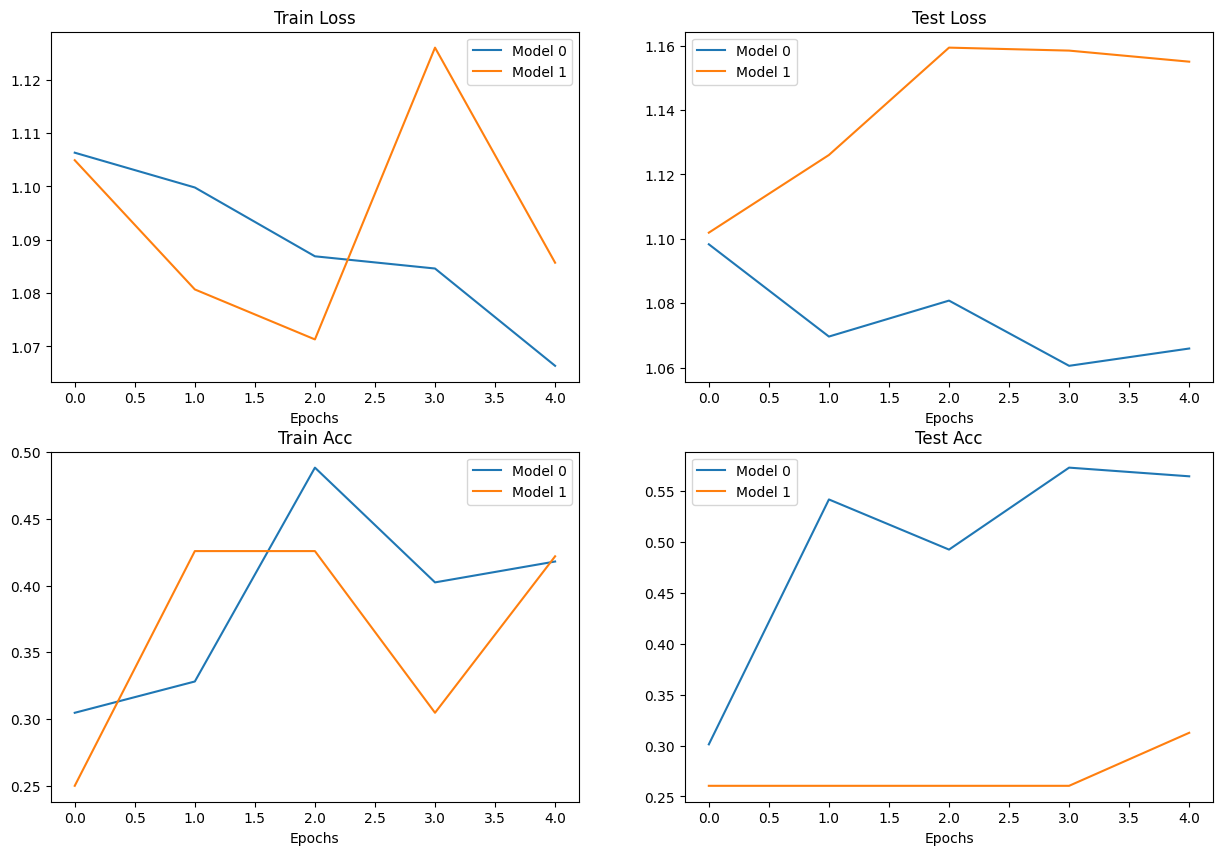

In [72]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Acc")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Acc")
plt.xlabel("Epochs")
plt.legend();